# Import Libraries

In [3]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from tensorflow.keras import backend

# Load dataset

In [4]:
def data_set(dir_data):
    data=[]
    target=[]
    data_map = {
    'with_mask':1,
    'without_mask':0
    }
    skipped=0
    img_dims = (96,96,3)
    nRowsRead = 1000 # specify 'None' if want to read whole file
    # _annotations.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
    root=dir_data+'_annotations.csv'
    df1 = pd.read_csv(root)
    df1.dataframeName = '_annotations.csv'
    nRow, nCol = df1.shape
    for i in range(len(df1)):
        without_mask='without_mask'
        k=dir_data+df1['filename'][i]
        #image=cv2.imread(k, cv2.IMREAD_GRAYSCALE)
        image=cv2.imread(k)
        xmin=int(df1['xmin'][i])
        ymin=int(df1['ymin'][i])
        xmax=int(df1['xmax'][i])
        ymax=int(df1['ymax'][i])
        image=image[ymin:ymax,  xmin:xmax]
        '''if(image.shape[0]>0 and image.shape[1]>0):
            image = cv2.resize(image, (image.shape[0],image.shape[1]))
            image = img_to_array(image)'''
        try:
                # resizing to (50 x 50)
                image = cv2.resize(image,(70,70))
        except Exception as E:
                skipped += 1
                print(E)
                continue
        if(df1['class'][i]=='mask'):
            without_mask='with_mask'
        image=img_to_array(image)
        data.append(image)
        target.append(data_map[without_mask])
    """odata=data.copy()
    ndata=[]
    for i in odata:
        img=i.reshape((*i.shape,1))
        img=tf.convert_to_tensor(img)
        ndata.append(tf.image.grayscale_to_rgb(img).numpy()/255.)
    data=ndata.copy()"""
    data = np.array(data, dtype="float") / 255.0
    #data = np.array(data)
    target = tf.keras.utils.to_categorical(np.array(target), num_classes=2)
    return data, target

OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function cv::resize

AxesImage(54,36;334.8x217.44)
shape= (70, 70, 3)


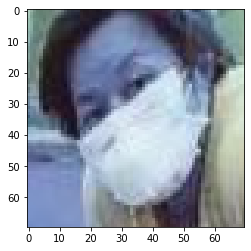

In [5]:
training_data, training_target=data_set('RawDataset/train/')
testing_data, testing_target=data_set('RawDataset/test/')
valid_data, valid_target=data_set('RawDataset/valid/')
print(plt.imshow(training_data[0]))
print('shape=',np.shape(training_data[1]))

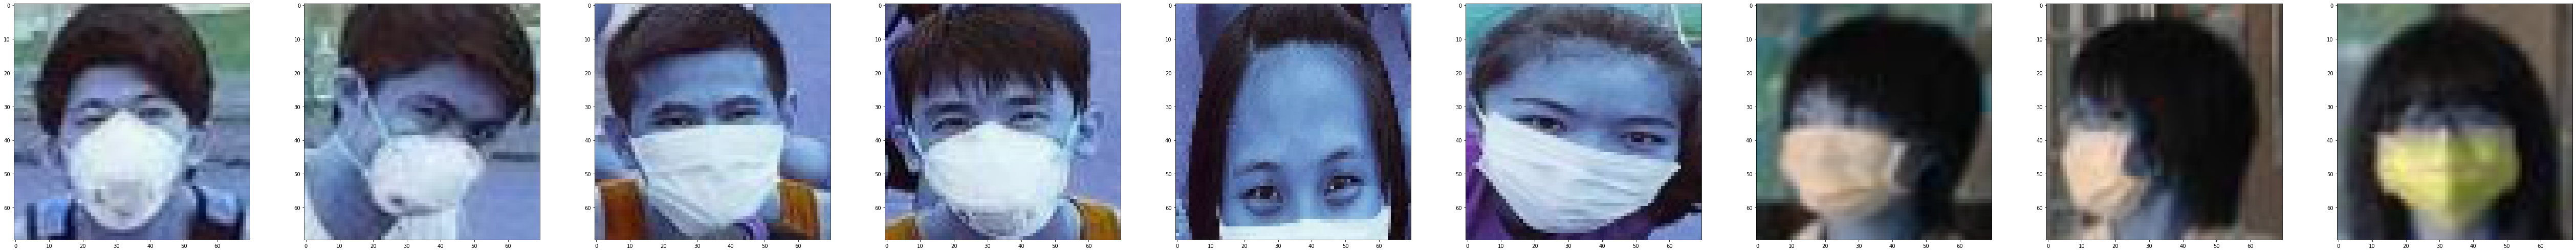

In [6]:
plt.figure(0, figsize=(100,100))
for i in range(1,10):
    plt.subplot(10,10,i)
    plt.imshow(training_data[i])
    #print(plt.imshow(training_data[i][0]))
    #print(training_data[i][1])
    #if(training_data[i][1]==1):
     #   print(plt.imshow(training_data[i][0]))

In [7]:
img_shape=training_data[0].shape
print(img_shape)
print(training_target.shape)
depth, height, width=3, img_shape[0], img_shape[1]
img_shape=(height, width, depth)
chanDim=-1
print(img_shape)
if backend.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        img_shape = (depth, height, width)
        chanDim = 1

(70, 70, 3)
(695, 2)
(70, 70, 3)


In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [9]:
model=Sequential()

model.add(layers.Conv2D(32,(3,3),input_shape=img_shape))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2,activation='softmax'))
'''
model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(2))
    model.add(Activation("sigmoid"))
'''
adam =tf.keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0

In [11]:
#from keras.utils import to_categorical
#training_target = to_categorical(training_target)
history = model.fit(x=training_data,
                   y=training_target,
                   batch_size=10,
                   epochs=10,
                   validation_split=0.2,
                   verbose=2,
                   shuffle=True) 

Train on 556 samples, validate on 139 samples
Epoch 1/10
556/556 - 11s - loss: 0.3999 - accuracy: 0.8363 - val_loss: 0.5170 - val_accuracy: 0.7122
Epoch 2/10
556/556 - 7s - loss: 0.2751 - accuracy: 0.8525 - val_loss: 0.3358 - val_accuracy: 0.7770
Epoch 3/10
556/556 - 9s - loss: 0.2440 - accuracy: 0.8723 - val_loss: 0.2892 - val_accuracy: 0.8058
Epoch 4/10
556/556 - 7s - loss: 0.2254 - accuracy: 0.8741 - val_loss: 0.5680 - val_accuracy: 0.7626
Epoch 5/10
556/556 - 7s - loss: 0.2134 - accuracy: 0.8723 - val_loss: 0.2896 - val_accuracy: 0.8561
Epoch 6/10
556/556 - 7s - loss: 0.2365 - accuracy: 0.8939 - val_loss: 0.2941 - val_accuracy: 0.7914
Epoch 7/10
556/556 - 7s - loss: 0.1922 - accuracy: 0.9101 - val_loss: 0.2480 - val_accuracy: 0.8921
Epoch 8/10
556/556 - 7s - loss: 0.2043 - accuracy: 0.9101 - val_loss: 0.2676 - val_accuracy: 0.8561
Epoch 9/10
556/556 - 7s - loss: 0.1972 - accuracy: 0.9137 - val_loss: 0.2639 - val_accuracy: 0.8633
Epoch 10/10
556/556 - 7s - loss: 0.2038 - accuracy: 0

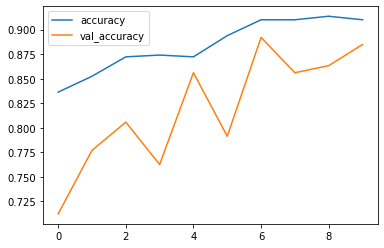

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [13]:
testing_data.shape

(96, 70, 70, 3)

In [16]:
#from keras.utils import to_categorical
#testing_target = to_categorical(testing_target)
model.evaluate(testing_data, testing_target)

32/96 [=========>....................] - ETA: 0s

ValueError: Dimensions must be equal, but are 32 and 64 for 'loss/dense_1_loss/softmax_cross_entropy_with_logits' (op: 'SoftmaxCrossEntropyWithLogits') with input shapes: [32,2], [64,2].

In [15]:
model.save('cnn.h5')